In [1]:
import numpy as np
import tensorflow as tf

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

test_data = mnist.test.images  # Returns np.array
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [4]:
train_labels

array([7, 3, 4, ..., 5, 6, 8])

## obejct detail [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape)

In [5]:
# tensor 't' is [[[1, 1, 1],
#                 [2, 2, 2]],
#                [[3, 3, 3],
#                 [4, 4, 4]],
#                [[5, 5, 5],
#                 [6, 6, 6]]]
# tensor 't' has shape [3, 2, 3]
# pass '[-1]' to flatten 't'
# tf.reshape(t, [-1]) ==> [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]
# reshape(t, [2, -1]) ==> [[1, 1, 1, 2, 2, 2, 3, 3, 3],
#                          [4, 4, 4, 5, 5, 5, 6, 6, 6]]
# -1 代表著撐開所有數值


train_x = tf.reshape(train_data, [-1, 28, 28, 1])
test_x = tf.reshape(test_data, [-1, 28, 28, 1])

train_y = train_labels
test_y = test_labels

x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.int32)

Convolutional Layer #1

Computes 32 features using a 5x5 filter with [ReLU activation](https://zh.wikipedia.org/wiki/线性整流函数).

Padding is added to preserve width and height.

Input Tensor Shape: [batch_size, 28, 28, 1]

Output Tensor Shape: [batch_size, 28, 28, 32]

In [6]:
# 把它捲及一個單位向量包含後五個單位向量來增加特徵

conv1 = tf.layers.conv2d(
    inputs=x,
    filters=32,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)

Pooling Layer #1

First max pooling layer with a 2x2 filter and stride of 2

Input Tensor Shape: [batch_size, 28, 28, 32]

Output Tensor Shape: [batch_size, 14, 14, 32]

## object detail : [tf.layers.max_pooling2d](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d)

In [7]:
# 再將兩行兩列的特徵合併成單一特徵

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

捲及 (Convolutional) 增加單一資訊的特徵後，在使用池來組 (Pooling) 成特定特徵

下面在鏡行一次，來提取更高階級的特徵。

In [8]:
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)

In [9]:
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

In [10]:
conv1

<tf.Tensor 'conv2d/Relu:0' shape=(?, 28, 28, 32) dtype=float32>

In [11]:
pool1

<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 14, 14, 32) dtype=float32>

In [12]:
conv2

<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 14, 14, 64) dtype=float32>

In [13]:
pool2

<tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>

In [14]:
#攤平矩正

pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

In [15]:
pool2_flat

<tf.Tensor 'Reshape_2:0' shape=(?, 3136) dtype=float32>

In [16]:
# 用 1024個神經元去吸附這些特徵

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

In [17]:
dense

<tf.Tensor 'dense/Relu:0' shape=(?, 1024) dtype=float32>

In [18]:
# 學習 0.4 的區域，也就代表會剃除 0.6 的內容

dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=True)

In [19]:
dropout

<tf.Tensor 'dropout/dropout/mul:0' shape=(?, 1024) dtype=float32>

In [20]:
# 噴出十個單位的成績

logits = tf.layers.dense(inputs=dropout, units=10)

In [21]:
predictions = {
    # Generate predictions (for PREDICT and EVAL mode)
    "classes": tf.argmax(input=logits, axis=1),
    # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
    # `logging_hook`.
    "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
}

In [22]:
# 錯誤比照

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

In [23]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

[tf.train.get_global_step](https://www.tensorflow.org/api_docs/python/tf/train/get_global_step)

In [24]:
train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())

In [25]:
# Creates a session with log_device_placement set to True.

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [26]:
saver = tf.train.Saver()

In [27]:
init = tf.initialize_all_variables()
sess.run(init)

# tf.reset_default_graph()
# saver.restore(sess, "mnist")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [28]:
# Placeholder 不吃 tensor
train_feed_x = sess.run(train_x)

In [29]:
train_feed_x.shape

(55000, 28, 28, 1)

In [30]:
import random

In [59]:
#data is to big in gpu
for i in range(10):
    for ii in range(500):
        data_start = random.randint(0,35000)
        data_end = data_start + 20000
        sess.run(train_op, feed_dict={x: train_feed_x[data_start:data_end], y: train_y[data_start:data_end]})

    print("saving %f" % i)
    saver.save(sess, "./mnist.ckpt", global_step=i)

saving 0.000000
saving 1.000000
saving 2.000000
saving 3.000000
saving 4.000000
saving 5.000000
saving 6.000000
saving 7.000000
saving 8.000000
saving 9.000000


In [60]:
import matplotlib.pyplot as plt

In [76]:
image = np.array(train_feed_x[1])
image.shape

(28, 28, 1)

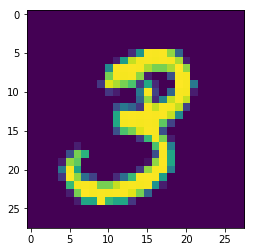

In [77]:
plt.imshow(image.squeeze())
plt.show()

In [78]:
train_y[1]

3

In [79]:
test_predictions = sess.run(predictions, feed_dict={x: [image]})

In [80]:
test_predictions

{'classes': array([3], dtype=int64),
 'probabilities': array([[7.7158969e-04, 6.7347632e-05, 1.5217328e-03, 9.8557997e-01,
         3.8006708e-06, 8.2715019e-04, 1.4048892e-06, 1.2710807e-03,
         6.5395134e-03, 3.4165552e-03]], dtype=float32)}

In [81]:
# tf.argmax in predictions mode
test_predictions['classes']

array([3], dtype=int64)

In [82]:
np.argmax(test_predictions['probabilities'])

3

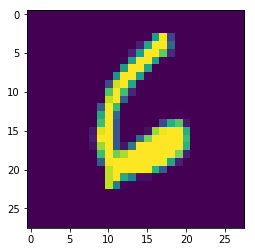

6


In [83]:
image = np.array(train_feed_x[3])
plt.imshow(image.squeeze())
plt.show()
print(train_y[3])

In [84]:
test_predictions = sess.run(predictions, feed_dict={x: [image]})

In [85]:
np.argmax(test_predictions['probabilities'])

6

## mnist [教學](https://www.tensorflow.org/tutorials/layers)

## code [link](https://github.com/tensorflow/tensorflow/blob/r1.7/tensorflow/examples/tutorials/layers/cnn_mnist.py)